# part0: imports

In [1]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
from tqdm import tqdm
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection

import torch

import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import lstm
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    %run "fig3.ipynb"

    print('Done')

Done


# Part 1

functions that plot each panel.


---

monkey population CCA plot

In [2]:
@utility.report
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

In [3]:
@utility.report
def plot_monkey_cca_prep(ax, ax_hist, full_list_MCx, allDFs_MCx):
    defs = monkey_defs
    
    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]
    AllData1 = dt.get_data_array(side1df, monkey_defs.prep_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData2 = dt.get_data_array(side2df, monkey_defs.prep_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    # lower bound
    len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))
    
    single_FileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            single_FileList1.append((I,J))
    n_iter = params.n_iter * 10
    side1df = [allDFs_MCx[i] for i,_ in single_FileList1]
    side2df = [allDFs_MCx[j] for _,j in single_FileList1]
    AllData1 = defs._get_data_array(side1df, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    AllData1_ = defs._get_data_array(side2df, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData1_.shape),axis=0)

    CCsL=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData1_):
        r = []
        for n in range(n_iter):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)

            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T

    # Upper bound
    single_FileList1 = []
    for I, _ in enumerate(full_list_MCx):
        single_FileList1.append(I)
    side1df = [allDFs_MCx[i] for i in single_FileList1]
    AllData1 = dt.get_data_array(side1df, monkey_defs.prep_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for session, sessionData in enumerate(AllData1):
        r = []
        for n in range(n_iter):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # plotting
    x_ = np.arange(1,monkey_defs.n_components+1)
    utility.shaded_errorbar(ax, x_, allCCs, color=params.colors.MainCC, marker = 'o')
    utility.shaded_errorbar(ax, x_, CCsU, color=params.colors.UpperCC, marker = '<', ls='--')
    utility.shaded_errorbar(ax, x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':')

    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,monkey_defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Canonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,monkey_defs.n_components])
    ax.spines['left'].set_bounds([0,1])
    
    #plot the hist
    bins = np.arange(0,1,0.05)
    ax_hist.xaxis.set_visible(False)
    ax_hist.set_facecolor('None')
    ax_hist.spines['bottom'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['left'].set_bounds([0,1])
    ax_hist.set_ylim([-.05,1])
    ax_hist.hist(allCCs[:4,:].mean(axis=0), bins=bins, density=True, label=f'Across $(n={allCCs.shape[1]}$)',
            color=params.colors.MainCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsU[:4,:].mean(axis=0), bins=bins, density=True,label=f'Within ($n={CCsU.shape[1]}$)',
            color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsL[:4,:].mean(axis=0), bins=bins, density=True, label=f'Control ($n={CCsL.shape[1]}$)',
            color=params.colors.LowerCC, alpha=.8, orientation='horizontal')
    
    ax_hist.tick_params('y', direction='out')
    ax_hist.set_yticklabels([])
    ax_hist.legend(loc=(0,-.05))

Executed: `plot_monkey_cca_prep` in 3.7s


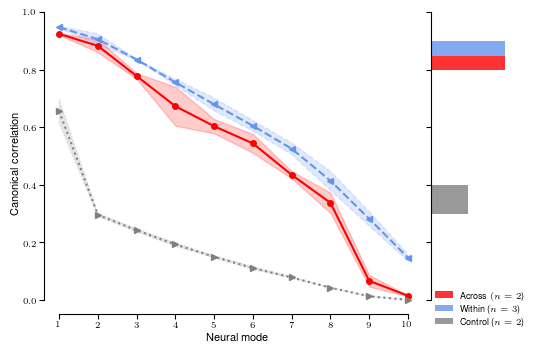

In [11]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

    ax = fig.add_subplot(gs[0])
    ax_ = fig.add_subplot(gs[1])

    
    # full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_cca_prep(ax,ax_, full_list_MCx[10:13], allDFs_MCx)
    
    plt.show()

---

decoding for monkeys

In [ ]:
@utility.report
def plot_monkey_target_decoding(ax, full_list, allDFs):
    defs = monkey_defs
    classifier_model = GaussianNB

    reg_scores = []
    for i, df in enumerate(allDFs):
        if 'J' in df.monkey[0]:
            continue  # remove Jaco from this analysis
        AllData = dt.get_data_array([df], defs.prep_epoch, area=defs.areas[2], model=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)

        AllData1 = AllData[0,...]
        _,n_trial,n_time,n_comp = AllData1.shape
        # resizing
        X1 = AllData1.reshape((-1,n_comp*n_time))
        AllTar = np.repeat(np.arange(defs.n_targets),n_trial)
        # train the decoder
        _score=cross_val_score(classifier_model(),X1,AllTar,scoring='accuracy', cv=10).mean()
        reg_scores.append((i,_score))
    pop_score_within_day = []
    for _,scores in reg_scores:
        pop_score_within_day.append(scores)
    pop_score_within_day = np.array(pop_score_within_day)


    #=================================
    pairIndex_across = []
    for i, (animal1,session1) in enumerate(full_list):
        pairIndex_across.append((i,[]))
        for j, (animal2,session2) in enumerate(full_list):
            if animal1 == animal2: continue
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue
            if 'J' in animal1 or 'J' in animal2: continue  # remove Jaco from this analysis
            pairIndex_across[-1][1].append(j)
    pairIndex_across = [(i,j) for i,jList in pairIndex_across for j in jList]
    
    reg_scores_across = []
    for id1, testId in pairIndex_across:
        AllData = dt.get_data_array([allDFs[id1],allDFs[testId]], defs.prep_epoch, area=defs.areas[2], model=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)

        AllData1 = AllData[0,...] 
        AllData2 = AllData[1,...]
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
        AllData1 = AllData1[:,:n_trial,:n_time,:]
        AllData2 = AllData2[:,:n_trial,:n_time,:]

        # resizing
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))

        *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
        U = U.reshape((-1,n_comp*n_time))
        V = V.reshape((-1,n_comp*n_time))
        AllTar = np.repeat(np.arange(defs.n_targets),n_trial)
        trial_index = np.arange(len(AllTar))
        params.rng.shuffle(trial_index)
        X_train, Y_train = U[trial_index,:], AllTar[trial_index]
        params.rng.shuffle(trial_index)
        X_test, Y_test   = V[trial_index,:], AllTar[trial_index]

        # train the decoder
        classifier = classifier_model()
        classifier.fit(X_train, Y_train)
        # test the decoder
        _score = classifier.score(X_test,Y_test)
        reg_scores_across.append((id1,testId,_score))
    pop_score_across_animals = []
    for _,_,scores in reg_scores_across:
        pop_score_across_animals.append(scores)
    pop_score_across_animals = np.array(pop_score_across_animals)

    #=======================================
    reg_latent_scores = []
    for id1, testId in pairIndex_across:
        AllData = dt.get_data_array([allDFs[id1],allDFs[testId]], defs.prep_epoch, area=defs.areas[2], model=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)

        AllData1 = AllData[0,...] 
        AllData2 = AllData[1,...]
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
        AllData1 = AllData1[:,:n_trial,:n_time,:]
        AllData2 = AllData2[:,:n_trial,:n_time,:]

        # resizing
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
    #     *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
        X1 = X1.reshape((-1,n_comp*n_time))
        X2 = X2.reshape((-1,n_comp*n_time))
        AllTar = np.repeat(np.arange(defs.n_targets),n_trial)
        trial_index = np.arange(len(AllTar))
        params.rng.shuffle(trial_index)
        X_train, Y_train = X1[trial_index,:], AllTar[trial_index]
        params.rng.shuffle(trial_index)
        X_test, Y_test   = X2[trial_index,:], AllTar[trial_index]
        # train the decoder
        classifier = classifier_model()
        classifier.fit(X_train, Y_train)
        # test the decoder
        _score = classifier.score(X_test,Y_test)
        reg_latent_scores.append((id1,testId,_score))
    pop_score_latent_across = []
    for _,_,scores in reg_latent_scores:
        pop_score_latent_across.append(scores)
    pop_score_latent_across = np.array(pop_score_latent_across)

#======================== PLOTTING

    bins = np.arange(0,1,0.05)
    ax.hist(pop_score_across_animals, bins=bins, density=True, label=r'Across (\textit{aligned})',
            alpha=.8, color=params.colors.MainCC)
    ax.hist(pop_score_latent_across, bins=bins, density=True, label=r'Across (\textit{unaligned})',
            alpha=.8, color=params.colors.LowerCC)
    ax.hist(pop_score_within_day, bins=bins, density=True, label='Within',
            alpha=.8, color=params.colors.UpperCC)

    ax.set_xlabel('Classification accuracy')
    ax.set_ylabel('Probability density', labelpad=1)
    ax.set_yticks([])
    ax.set_xlim([-.05,1])
    ax.legend(loc='upper left', bbox_to_anchor=(.2, 1))
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([0,1])

Executed: `plot_monkey_target_decoding` in 11.9s


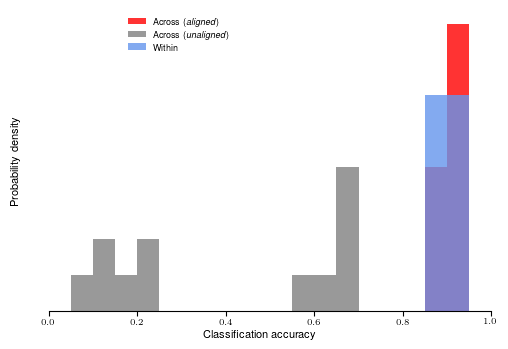

In [12]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()

    
    # full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_target_decoding(ax, full_list_MCx[10:15], allDFs_MCx)

    plt.show()

---

Mouse CCA plot

In [5]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

In [6]:
@utility.report
def plot_mouse_str_cca(ax, ax_hist, allDFs_Str):
    defs = mouse_defs

    pairFileList2 = []
    for I, df1 in enumerate(allDFs_Str):
        for J, df2 in enumerate(allDFs_Str):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList2.append((I,J))

    side1df = [allDFs_Str[i] for i,_ in pairFileList2]
    side2df = [allDFs_Str[j] for _,j in pairFileList2]
    AllData1_ = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[1], model=defs.n_components)
    AllData2_ = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[1], model=defs.n_components)
    _,_, min_trials_, min_time_,_ = np.min((AllData1_.shape,AllData2_.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
        data1 = np.reshape(sessionData1[:,:min_trials_,:min_time_,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials_,:min_time_,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    # upper bound
    AllData2 = dt.get_data_array(allDFs_Str, defs.exec_epoch, area=defs.areas[1], model=defs.n_components)
    n_shared_trial2 = AllData2.shape[2]
    trialList2 = np.arange(n_shared_trial2)
    n_iter = params.n_iter * 10
    CCsU=[]
    for sessionData in AllData2:
        r = []
        for n in range(n_iter):
            params.rng.shuffle(trialList2)
            # non-overlapping randomised trials
            trial1 = trialList2[:n_shared_trial2//2]
            trial2 = trialList2[-(n_shared_trial2//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # lower bound
    len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))
    pairFileList2 = []
    for I, df1 in enumerate(allDFs_Str):
        for J, df2 in enumerate(allDFs_Str):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList2.append((I,J))
    side1df = [allDFs_Str[i] for i,_ in pairFileList2]
    side2df = [allDFs_Str[j] for _,j in pairFileList2]
    AllData1_ = dt.get_data_array(side1df, area=defs.areas[1], model=defs.n_components)
    AllData2_ = dt.get_data_array(side2df, area=defs.areas[1], model=defs.n_components)
    _,_, min_trials_, min_time_,_ = np.min((AllData1_.shape,AllData2_.shape),axis=0)

    CCsL=[]
    for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
        r = []
        for n in range(n_iter):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            time_idx = params.rng.integers(min_time_-len_trial)

            data1 = np.reshape(sessionData1_sh[:,:min_trials_,time_idx:time_idx+len_trial,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials_,time_idx:time_idx+len_trial,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T


    #====================================PLOTTING
    
    x_ = np.arange(1,defs.n_components+1)
    utility.shaded_errorbar(ax, x_, allCCs, color=params.colors.MainCC, marker = 'o')
    utility.shaded_errorbar(ax, x_, CCsU, color=params.colors.UpperCC, marker = '<', ls='--')
    utility.shaded_errorbar(ax, x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':')

    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Canonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,defs.n_components])
    ax.spines['left'].set_bounds([0,1])
    
    #plot the hist

    bins = np.arange(0,1,0.05)
    ax_hist.xaxis.set_visible(False)
    ax_hist.set_facecolor('None')
    ax_hist.spines['bottom'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['left'].set_bounds([0,1])
    ax_hist.set_ylim([-.05,1])
    ax_hist.hist(allCCs[:4,:].mean(axis=0), bins=bins, density=True, label=f'($n={allCCs.shape[1]}$)',
            color=params.colors.MainCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsU[:4,:].mean(axis=0), bins=bins, density=True,label=f'($n={CCsU.shape[1]}$)',
            color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsL[:4,:].mean(axis=0), bins=bins, density=True, label=f'($n={CCsL.shape[1]}$)',
            color=params.colors.LowerCC, alpha=.8, orientation='horizontal')
    
    ax_hist.tick_params('y', direction='out')
    ax_hist.set_yticklabels([])
    ax_hist.legend(loc=(0,-.05))

Executed: `plot_mouse_str_cca` in 8.3s


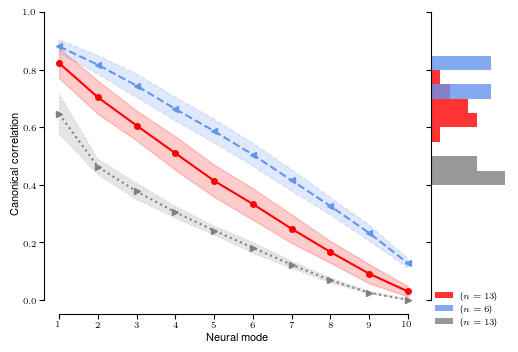

In [13]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

    ax = fig.add_subplot(gs[0])
    ax_ = fig.add_subplot(gs[1])

    
    # _, allDFs_Str = get_full_mouse_data()
    
    plot_mouse_str_cca(ax,ax_, allDFs_Str)
    
    plt.show()

---

STR decoding

In [2]:
@utility.report
def plot_str_decoding(ax, AllDFs):
    defs = mouse_defs
    
    #=========================
    within_score = {}
    aligned_score = {}
    unaligned_score = {}
    for i, df1 in enumerate(tqdm(AllDFs)):
        animal1 = df1.mouse[0]

        AllData, AllVel = defs.get_data_array_and_vel([df1], defs.exec_epoch_decode, area=defs.areas[1],
                                                    n_components=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]
        *_,n_time,n_comp = AllData.shape
        AllData1 = AllData[0,...]
        AllVel1 = AllVel[0,...]
        # resizing
        X1 = AllData1.reshape((-1, n_time, n_comp))
        AllVel1 = AllVel1.reshape((-1,n_time,3))

        fold_score =[]
        kf = KFold(n_splits=10)
        for train_index, test_index in kf.split(X1[:,0,0]):
            x_train, x_test = X1[train_index,...], X1[test_index,...]
            y_train, y_test = AllVel1[train_index,...], AllVel1[test_index,...]

            lstm_model = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=3)
            lstm_model.fit(x_train=x_train, y_train=y_train, epochs = 10)
            lstm_model.predict(x_test, y_test)
            fold_score.append(lstm_model.score)
        fold_score = np.median(fold_score)
        within_score[df1.file[0]] = fold_score


        aligned_score[df1.file[0]] = {}
        unaligned_score[df1.file[0]] = {}
        for j, df2 in enumerate(AllDFs):
            if j < i: continue
            animal2 = df2.mouse[0]
            if animal1 == animal2: continue
            
            #================================
            # Unaligned
            AllData, AllVel = defs.get_data_array_and_vel([df1, df2], defs.exec_epoch_decode,
                                                          area=defs.areas[1], n_components=defs.n_components)

            # adding history
            AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
            AllData = AllData[...,defs.MAX_HISTORY:,:]
            AllVel = AllVel[...,defs.MAX_HISTORY:,:]
            AllData1 = AllData[0,...]
            AllData2 = AllData[1,...]
            AllVel1 = AllVel[0,...]
            AllVel2 = AllVel[1,...]
            # resizing
            _,n_trial,n_time,n_comp = AllData1.shape
            X1 = AllData1.reshape((-1,n_comp))
            X2 = AllData2.reshape((-1,n_comp))
            AllVel1 = AllVel1.reshape((-1,n_time,3))
            AllVel2 = AllVel2.reshape((-1,n_time,3))

            *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
            U = U.reshape((-1,n_time,n_comp))
            V = V.reshape((-1,n_time,n_comp))
            X1 = X1.reshape((-1,n_time,n_comp))
            X2 = X2.reshape((-1,n_time,n_comp))

            lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=3)
            lstm_model.fit(x_train=U, y_train=AllVel1)
            lstm_model.predict(V, AllVel2)
            aligned_score[df1.file[0]][df2.file[0]] = lstm_model.score.mean()

            #================================
            # Unaligned
            lstm_model = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=3)
            lstm_model.fit(x_train=X1, y_train=AllVel1)
            lstm_model.predict(X2, AllVel2)
            unaligned_score[df1.file[0]][df2.file[0]] = lstm_model.score.mean()


    # return within_score, aligned_score, unaligned_score
    #======================== PLOTTING
    pop_within = np.array(list(within_score.values()))
    pop_aligned = np.array([val for key in aligned_score for val in aligned_score[key].values()])
    pop_unaligned = np.array([val for key in unaligned_score for val in unaligned_score[key].values()])

    ax.errorbar(1, pop_aligned.mean(), np.std(pop_aligned), label='Across\n' r'(\textit{aligned})',
                color=params.colors.MainCC, fmt='-o', capsize=1.5)    
    ax.errorbar(0, pop_unaligned.mean(), np.std(pop_unaligned), label='Across\n' r'(\textit{unaligned})',
                color=params.colors.LowerCC, fmt='-o', capsize=1.5)
    ax.errorbar(2, pop_within.mean(), np.std(pop_within), label='Within',
                color=params.colors.UpperCC, fmt='-o', capsize=1.5)


    for file1, nested_dict in aligned_score.items():
        wi_val1 = within_score[file1]
        for file2, al_val in nested_dict.items():
            wi_val2 = within_score[file2]
            unal_val = unaligned_score[file1][file2]
            ax.plot([0,1,2], [unal_val, al_val, wi_val1],
                    color='gray', lw=.2, zorder=-5)
            ax.plot([1,2], [al_val, wi_val2],
                    color='gray', lw=.2, zorder=-5)

    ax.set_xlim([-0.2,2.2])
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['Across\n' r'(\textit{unaligned})',
                        'Across\n' r'(\textit{aligned})',
                        'Within'])
    ax.set_ylabel('Prediction accuracy ($R^2$)')
    ax.set_ylim([-.05,1])
    # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([0,2])
    ax.spines['left'].set_bounds([0,1])

Executed: `get_full_mouse_data` in 0.8s


100%|██████████| 6/6 [04:22<00:00, 43.83s/it]

Executed: `plot_str_decoding` in 263.0s


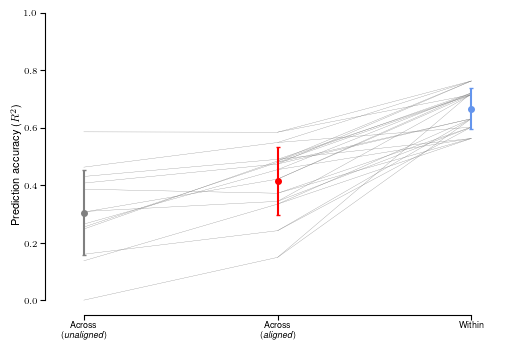

In [4]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()

    
    # _, allDFs_Str = get_full_mouse_data()
    
    plot_str_decoding(ax, allDFs_Str)
    
    plt.show()

# Part 2
Plot figure

Executed: `get_full_monkey_data` in 15.0s
Executed: `plot_monkey_cca_prep` in 145.4s
Executed: `plot_monkey_target_decoding` in 137.2s
Executed: `get_full_mouse_data` in 0.7s
Executed: `plot_mouse_str_cca` in 7.8s


100%|██████████| 6/6 [04:27<00:00, 44.52s/it]


Executed: `plot_str_decoding` in 267.1s


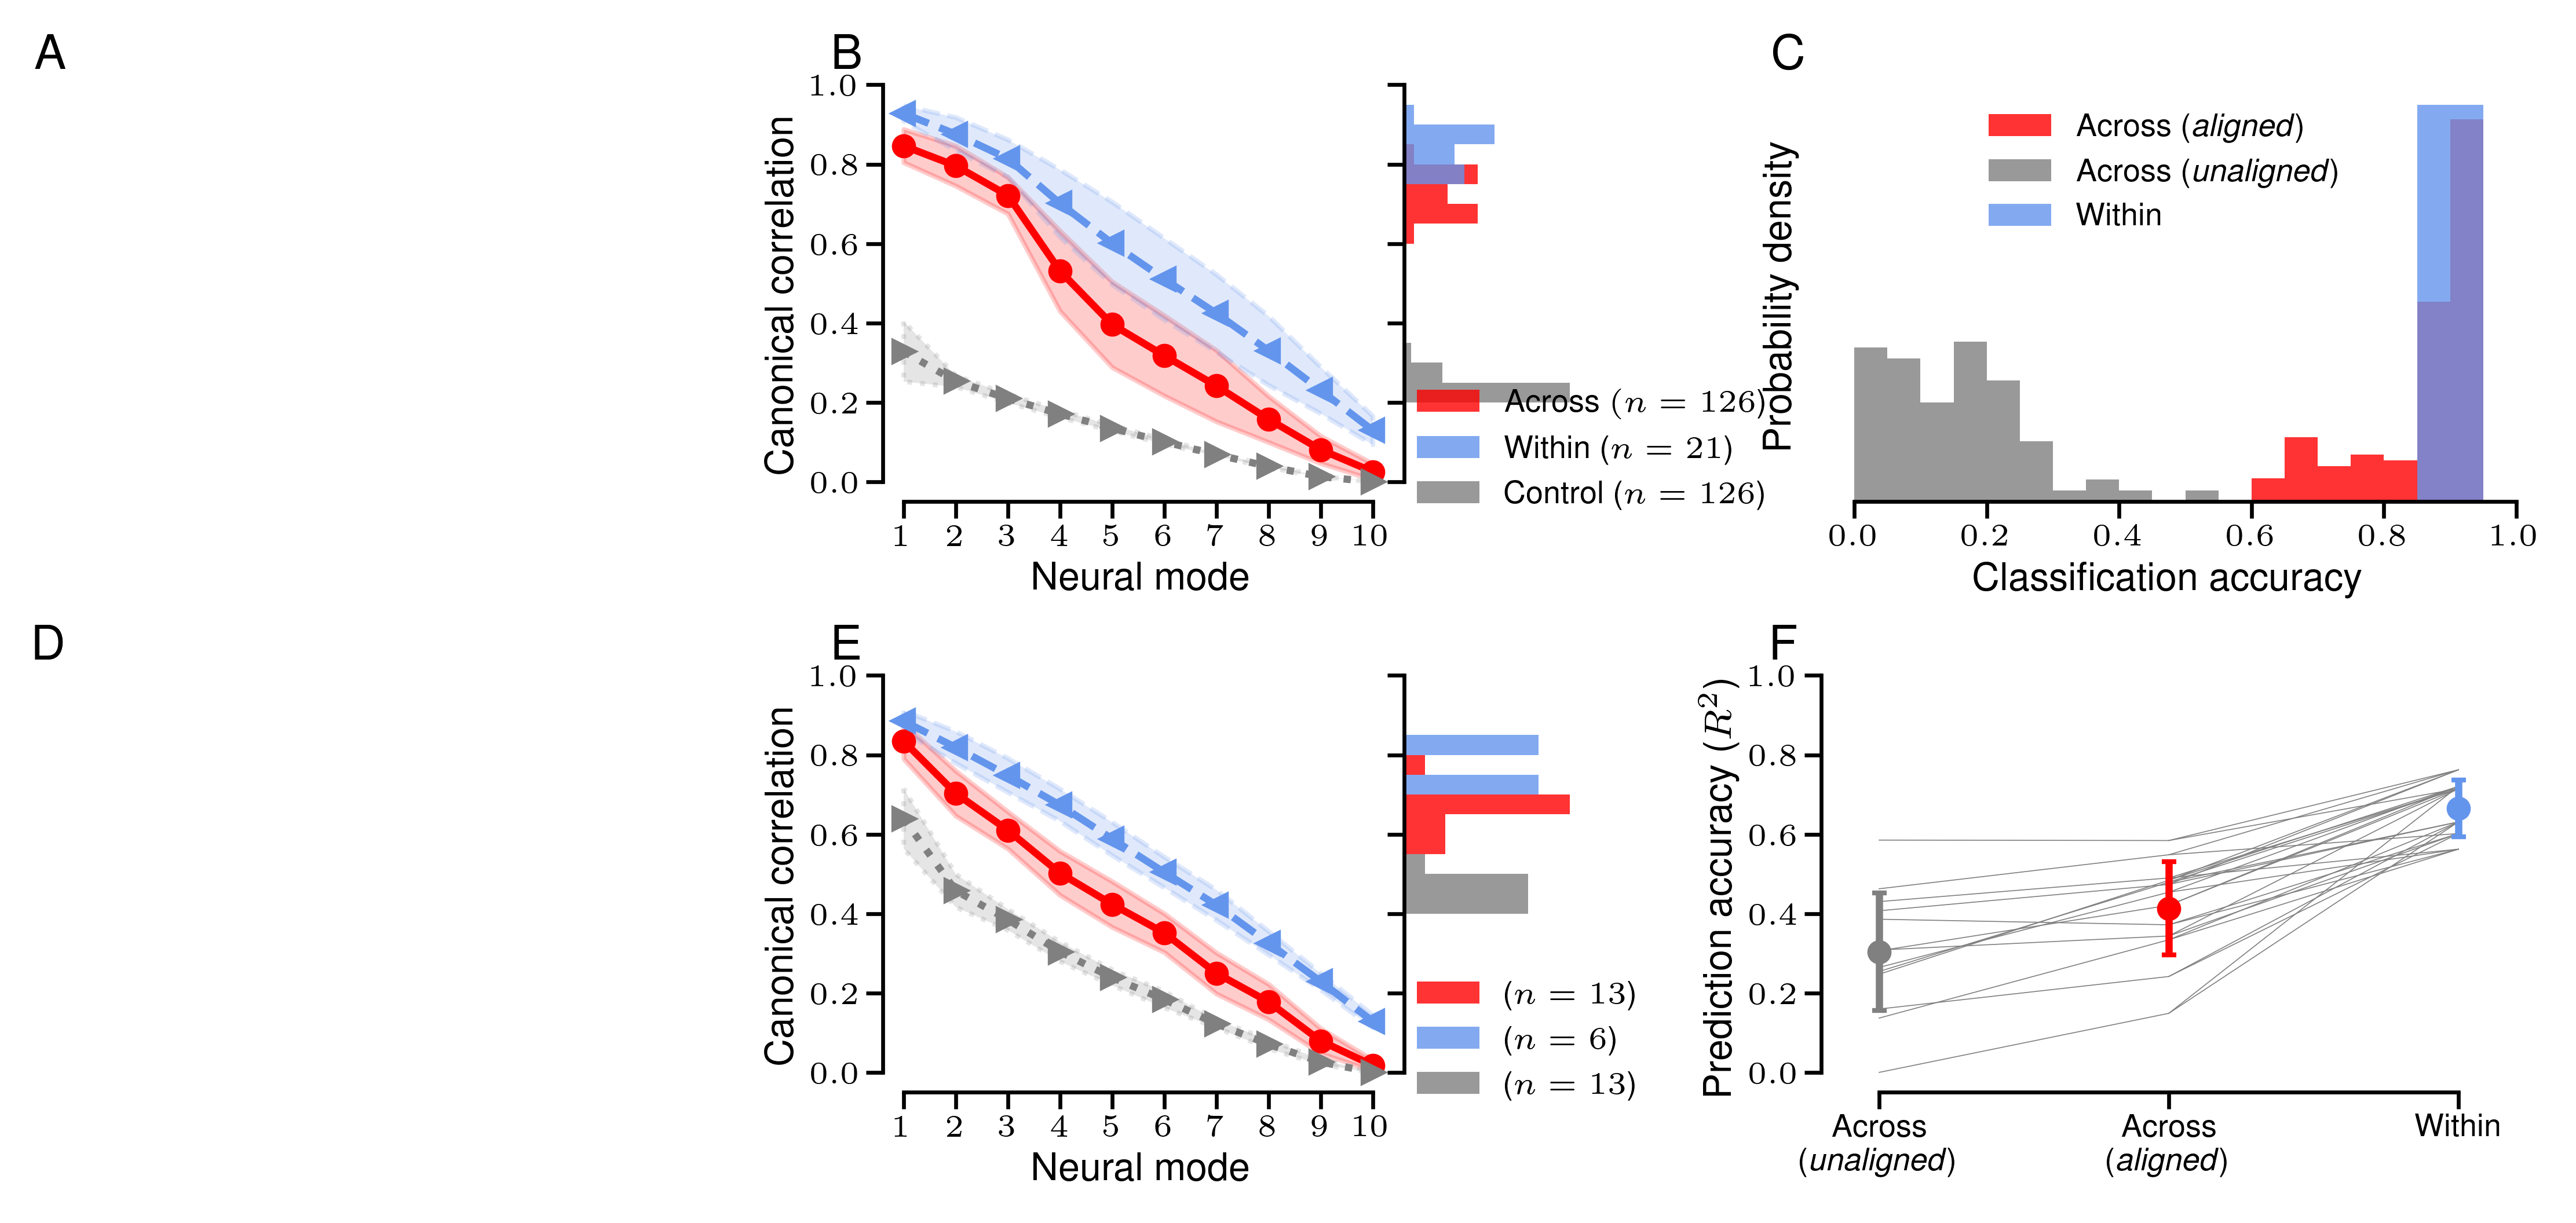

In [2]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    figsize= (params.LargeFig[0], params.panels.SmallH*2+.3)
    fig=plt.figure(figsize=figsize)
    
   

    ##########################################
    # 1: PREP schematics
    gs1   =utility.add_gridspec_abs(fig, nrows=1, ncols=1, top=figsize[1], 
                                    right=params.panels.schmatic[0],
                                    width=params.panels.schmatic[0],
                                    height=params.panels.cca_hist[1])
    ax1   =fig.add_subplot(gs1[0])
    ax1 = utility.phantom_axes(ax1)
    ax1.set_facecolor([1,0,0,0])


    
    
    ##########################################
    # 2: CCA plot for prep
    gs2 = fig.add_gridspec(nrows=1, ncols=2,  width_ratios=(params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]),
                           left=gs1.right+(.3/figsize[0]),  # .7" offset
                           right=gs1.right+ (.3/figsize[0]) + params.panels.cca_hist[0]/figsize[0],
                           bottom=gs1.bottom,
                           top=gs1.top,
                           wspace=0)

    ax2 = fig.add_subplot(gs2[0])
    ax2_ = fig.add_subplot(gs2[1])
    
    full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_cca_prep(ax2,ax2_, full_list_MCx, allDFs_MCx)
    

    
    
    ##########################################
    # 3: Decoding for prep
    gs3   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    top=figsize[1],
                                    right=figsize[0],
                                    width=params.panels.decoding_hist[0],
                                    height=params.panels.decoding_hist[1])

    ax3 = fig.add_subplot(gs3[0])

    
    plot_monkey_target_decoding(ax3, full_list_MCx, allDFs_MCx)

        
    
    ##########################################
    # 4: schematics STR
    gs4   =utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0, 
                                    bottom=gs1.bottom*figsize[1]-params.panels.schmatic[1],
                                    width=params.panels.schmatic[0],
                                    height=params.panels.cca_hist[1])
    ax4   =fig.add_subplot(gs4[0])
    ax4 = utility.phantom_axes(ax4)
    ax4.set_facecolor([0,0,0,0])

    
    
    
    ##########################################
    # 5: CCA plot for STR
    gs5 = fig.add_gridspec(nrows=1, ncols=2,  width_ratios=(params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]),
                           left=gs2.left,
                           right=gs2.right,
                           bottom=gs4.bottom,
                           top=gs4.top,
                           wspace=0)

    ax5 = fig.add_subplot(gs5[0])
    ax5_ = fig.add_subplot(gs5[1])
    
    
    _, allDFs_Str = get_full_mouse_data()
    
    plot_mouse_str_cca(ax5,ax5_, allDFs_Str)
    

    
    #########################################
    # 6: Decoding for STR
    gs6   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    top=gs5.top*figsize[1],
                                    right=figsize[0],
                                    width=params.panels.decoding_hist[0],
                                    height=params.panels.decoding_hist[1])

    ax6 = fig.add_subplot(gs6[0])


    plot_str_decoding(ax6, allDFs_Str)


    
    
#     fig.align_ylabels([ax1,ax4])
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    AXES=(ax1,ax2,ax3,ax4,ax5,ax6)
    OFFX=np.array([.02]*len(AXES))
    OFFY=np.array([.03]*len(AXES))
    # OFFX[[-1]]=0.12
    # OFFX[[1]]=0.06
    
    params.add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)

    fig.savefig(params.figPath / 'figure3.pdf', format='pdf', bbox_inches='tight')
    
    
    ##########################################
    # monkey schematics
 
    thisPath  =str(params.figPath / 'figure3.pdf')
    sketchPath=str(params.figPath / 'monkey-prep-schematic.pdf')
    if os.path.exists(sketchPath):
        f1=ppdf.PdfFileReader(thisPath).getPage(0)
        f2=ppdf.PdfFileReader(sketchPath).getPage(0)

        f1.mergeTranslatedPage(page2=f2, tx=10, ty=147, expand=False)

        writer=ppdf.PdfFileWriter()
        writer.addPage(f1)
        with open(thisPath,'wb') as f3:
            writer.write(f3)
